<a href="https://colab.research.google.com/github/Vakhranev/MDB/blob/main/Boxplots.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Импорт необходимых библиотек и определение вспомогательных функций

In [8]:
!pip install pymorphy2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 13.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=122f33a3f00b30dcae247a4e9a750450cfc9f0262784aa5e8ce5b11fe571ea78
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built docopt


In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
import re
import pymorphy2

# Создаем экземпляр морфологического анализатора pymorphy2
morph_analyzer = pymorphy2.MorphAnalyzer()

# Функция для лемматизации текста с сохранением части речи
def lemmatize_text(text):
    text = re.sub(r'[^а-яА-Я\s]', '', text)  # Удаление всех символов, кроме букв кириллицы и пробелов
    text = text.lower()
    words = re.findall(r'\b\w+\b', text)
    lemmas_pos = [(morph_analyzer.parse(word)[0].normal_form, morph_analyzer.parse(word)[0].tag.POS) for word in words if word.strip()]
    return lemmas_pos

# Функция для обработки папки с текстами студентов
def process_folder(folder_path):
    unique_lemmas_by_level = {}
    for file_path in glob.glob(folder_path + "/*.txt"):
        with open(file_path, "r", encoding='utf-8') as file:
            text = file.read()
            lemmas_pos = lemmatize_text(text)
            unique_lemmas_pos = list(set(lemmas_pos))  # Удаление неуникальных лемм
            unique_lemmas_by_level[file_path] = unique_lemmas_pos
    return unique_lemmas_by_level

Обработка текстов студентов

In [16]:
# Путь к папке с работами студентов
students_path = 'Students_texts'

# Обрабатываем папки с работами студентов
student_work = {}
folders = ['A1', 'A2', 'B1', 'B2']
for folder in folders:
    folder_path = os.path.join(students_path, folder)
    student_work[folder] = process_folder(folder_path)

# Проверка результатов обработки папки A1
print(student_work['A1'])

{'Students_texts/A1/Victoria_Lye_Entry3_ST.txt': [('день', 'NOUN'), ('ребёнок', 'NOUN'), ('мобилка', 'NOUN'), ('семья', 'NOUN'), ('мочь', 'VERB'), ('я', 'NPRO'), ('мой', 'ADJF'), ('сша', 'NOUN'), ('тоже', 'PRCL'), ('австралийка', 'NOUN'), ('помоему', 'ADVB'), ('каждый', 'ADJF'), ('сингапур', 'NOUN'), ('видеть', 'INFN'), ('быть', 'VERB'), ('понравиться', 'VERB'), ('с', 'PREP'), ('у', 'PREP'), ('сейчас', 'ADVB'), ('говорить', 'INFN'), ('много', 'ADVB'), ('жить', 'VERB'), ('есть', 'INFN'), ('это', 'PRCL'), ('хороший', 'ADJF'), ('в', 'PREP'), ('технология', 'NOUN'), ('понравиться', 'INFN'), ('и', 'CONJ'), ('когда', 'CONJ'), ('друг', 'NOUN'), ('они', 'NPRO')], 'Students_texts/A1/Nicholas_Fram_Entry3_ST .txt': [('гитара', 'NOUN'), ('не', 'PRCL'), ('дом', 'NOUN'), ('день', 'NOUN'), ('никогда', 'ADVB'), ('хотеть', 'VERB'), ('брат', 'NOUN'), ('или', 'CONJ'), ('он', 'NPRO'), ('человек', 'NOUN'), ('челавек', 'ADVB'), ('очень', 'ADVB'), ('мочь', 'VERB'), ('я', 'NPRO'), ('думать', 'VERB'), ('мой', 

Загрузка словаря Ляшевской и создание словаря соответствий тегов частей речи

In [23]:
import pandas as pd
import numpy as np

# Загрузка данных Ляшевской
df_lyashevskaya = pd.read_csv('freqrnc2011.csv', sep='\t')
df_lyashevskaya['Lemma'] = df_lyashevskaya['Lemma'].str.lower()

# Создание словаря соответствий тегов частей речи
pos_mapping = {
    'NOUN': 's',
    'VERB': 'v',
    'ADJF': 'a',
    'ADJS': 'a',
    'COMP': 'a',
    'INFN': 'v',
    'PRTF': 'v',
    'PRTS': 'v',
    'GRND': 'v',
    'NUMR': 'num',
    'ADVB': 'adv',
    'NPRO': 'spro',
    'PRED': 'adv',
    'PREP': 'pr',
    'CONJ': 'conj',
    'PRCL': 'part',
    'INTJ': 'intj'
}

# Функция для присвоения ранга леммам студента
def assign_ranks(lemmas_pos, df_lyashevskaya, pos_mapping):
    ranks = []
    for lemma, pos in lemmas_pos:
        mapped_pos = pos_mapping.get(pos, None)
        if mapped_pos:
            rank = df_lyashevskaya[(df_lyashevskaya['Lemma'] == lemma) & (df_lyashevskaya['PoS'] == mapped_pos)]['Freq(ipm)']
            if not rank.empty:
                ranks.append(rank.values[0])
            else:
                ranks.append(float('inf'))  # Для лемм, которых нет в словаре, присваиваем бесконечный ранг
        else:
            ranks.append(float('inf'))
    return ranks

Расчет MRR для каждого документа

In [24]:
# Функция для расчета MRR
def calculate_mrr(ranks):
    if len(ranks) == 0:
        return 0
    reciprocal_ranks = [1.0 / rank if rank != float('inf') else 0 for rank in ranks if rank > 0]
    if len(reciprocal_ranks) == 0:
        return 0
    return np.mean(reciprocal_ranks)

# Функция для обработки всех документов и расчета среднего MRR по каждому уровню
def process_all_documents(student_work, df_lyashevskaya, pos_mapping):
    mrr_scores = {level: [] for level in student_work.keys()}
    for level, works in student_work.items():
        for file, lemmas_pos in works.items():
            ranks = assign_ranks(lemmas_pos, df_lyashevskaya, pos_mapping)
            mrr = calculate_mrr(ranks)
            mrr_scores[level].append(mrr)
    return mrr_scores

# Подсчет MRR для всех документов
mrr_scores = process_all_documents(student_work, df_lyashevskaya, pos_mapping)

# Проверка MRR для уровня A1
print(mrr_scores['A1'])

[0.0020638812949055852, 0.0059361258778499685, 0.01738644035488864, 0.07968359390505221, 0.0017864263305666503, 0.0021701738263887665, 0.0013208584006417269, 0.018473641298962274, 0.02718911033174777, 0.004206551052412109, 0.018000810928427716, 0.007171521564141073, 0.044361834113524894, 0.040895021367191774, 0.050413912469946476, 0.022483356966926948, 0.054753147542176264, 0.03732595922888212, 0.03394322659267258, 0.04261584670256702, 0.0016254085191019295, 0.04274204217950385, 0.0028401062436669284, 0.0025577097027406973, 0.013381531951197458, 0.00908134279213721, 0.013247468308981948, 0.005192836705677636, 0.004649640531473169, 0.0010003488042438175, 0.0028466172597818827, 0.004514282386480977, 0.0030917768621899462, 0.0016629790933241156, 0.009409823025535212, 0.002874332299439154, 0.0021846009201244676, 0.013186111940117883, 0.01021041529179239, 0.04170993489261866, 0.028410579492482015, 0.030183657242044443, 0.07663753048406463, 0.11304153771083751, 0.0052042072948788026, 0.01512

Визуализация результатов

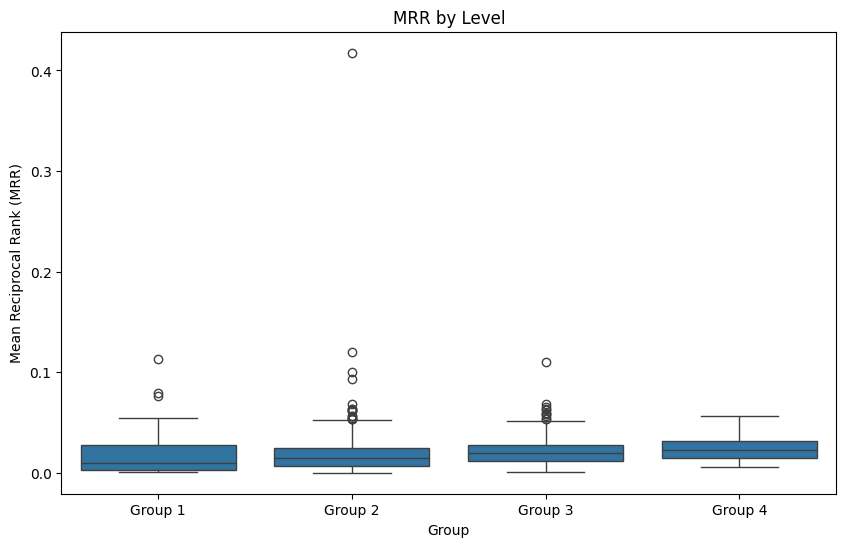

In [25]:
# Создание DataFrame для визуализации
mrr_data = []
for level, scores in mrr_scores.items():
    for score in scores:
        mrr_data.append({'Level': level, 'MRR': score})

df_mrr = pd.DataFrame(mrr_data)

# Переименование уровней для визуализации
df_mrr['Level'] = df_mrr['Level'].replace({'A1': 'Group 1', 'A2': 'Group 2', 'B1': 'Group 3', 'B2': 'Group 4'})

# Визуализация с использованием boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Level', y='MRR', data=df_mrr)
plt.title('MRR by Level')
plt.ylabel('Mean Reciprocal Rank (MRR)')
plt.xlabel('Group')
plt.show()

Импорт библиотек и загрузка данных

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Загрузка данных Ляшевской
df_lyashevskaya = pd.read_csv('freqrnc2011.csv', sep='\t')
df_lyashevskaya['Lemma'] = df_lyashevskaya['Lemma'].str.lower()

# Проверка данных
print(df_lyashevskaya.head())

  Lemma   PoS  Freq(ipm)    R   D    Doc
0     а  conj     8198.0  100  97  32332
1     а  intj       19.8   99  90    757
2     а  part        6.1   59  79    128
3     а     s        2.7   59  85    160
4    аа  intj        1.5   47  80     68


Создание текстовых файлов с леммами из топа, низа и случайными словами

In [3]:
# Функция для сохранения лемм в файл
def save_lemmas_to_file(lemmas, filename):
    with open(filename, 'w', encoding='utf-8') as file:
        for lemma in lemmas:
            file.write(f"{lemma}\n")

# Создание текстовых файлов
top_lemmas = df_lyashevskaya.sort_values(by='Freq(ipm)', ascending=False).head(1000)['Lemma'].tolist()
bottom_lemmas = df_lyashevskaya.sort_values(by='Freq(ipm)', ascending=True).head(1000)['Lemma'].tolist()
random_lemmas = df_lyashevskaya.sample(1000)['Lemma'].tolist()

save_lemmas_to_file(top_lemmas, 'top_lemmas.txt')
save_lemmas_to_file(bottom_lemmas, 'bottom_lemmas.txt')
save_lemmas_to_file(random_lemmas, 'random_lemmas.txt')

# Проверка содержимого файлов
print(open('top_lemmas.txt', 'r', encoding='utf-8').readlines()[:10])
print(open('bottom_lemmas.txt', 'r', encoding='utf-8').readlines()[:10])
print(open('random_lemmas.txt', 'r', encoding='utf-8').readlines()[:10])

['и\n', 'в\n', 'не\n', 'на\n', 'я\n', 'быть\n', 'он\n', 'с\n', 'что\n', 'а\n']
['перекачать\n', 'помешанный\n', 'касситерит\n', 'кастаньета\n', 'померанец\n', 'востроносый\n', 'поляризовать\n', 'поляризационный\n', 'бомжатник\n', 'полушка\n']
['заготовить\n', 'корниловец\n', 'перепад\n', 'возместить\n', 'членораздельно\n', 'седмица\n', 'верифицировать\n', 'теоретически\n', 'сфальшивить\n', 'патронташ\n']


Расчет MRR для каждого файла

In [4]:
# Функция для загрузки лемм из файла
def load_lemmas_from_file(filename):
    with open(filename, 'r', encoding='utf-8') as file:
        lemmas = [line.strip() for line in file.readlines()]
    return lemmas

# Присваиваем ранги леммам
df_lyashevskaya['Rank'] = df_lyashevskaya['Freq(ipm)'].rank(method='max', ascending=False)

# Проверка рангов
print(df_lyashevskaya.head())

# Функция для расчета MRR
def calculate_mrr(lemmas, df_lyashevskaya):
    ranks = []
    for lemma in lemmas:
        rank = df_lyashevskaya[df_lyashevskaya['Lemma'] == lemma]['Rank']
        if not rank.empty:
            ranks.append(rank.values[0])
        else:
            ranks.append(float('inf'))  # Для лемм, которых нет в словаре, присваиваем бесконечный ранг
    if len(ranks) == 0:
        return 0
    reciprocal_ranks = [1.0 / rank if rank != float('inf') else 0 for rank in ranks if rank > 0]
    if len(reciprocal_ranks) == 0:
        return 0
    return np.mean(reciprocal_ranks)

# Загрузка лемм из файлов
top_lemmas = load_lemmas_from_file('top_lemmas.txt')
bottom_lemmas = load_lemmas_from_file('bottom_lemmas.txt')
random_lemmas = load_lemmas_from_file('random_lemmas.txt')

# Расчет MRR
mrr_top = calculate_mrr(top_lemmas, df_lyashevskaya)
mrr_bottom = calculate_mrr(bottom_lemmas, df_lyashevskaya)
mrr_random = calculate_mrr(random_lemmas, df_lyashevskaya)

# Вывод MRR для проверки
print(f"MRR для топ-лемм: {mrr_top}")
print(f"MRR для нижних лемм: {mrr_bottom}")
print(f"MRR для случайных лемм: {mrr_random}")

  Lemma   PoS  Freq(ipm)    R   D    Doc     Rank
0     а  conj     8198.0  100  97  32332     10.0
1     а  intj       19.8   99  90    757   5263.0
2     а  part        6.1   59  79    128  12363.0
3     а     s        2.7   59  85    160  21418.0
4    аа  intj        1.5   47  80     68  29711.0
MRR для топ-лемм: 0.006440899412550489
MRR для нижних лемм: 3.151740686841975e-05
MRR для случайных лемм: 0.00023771602925106548


Визуализация результатов

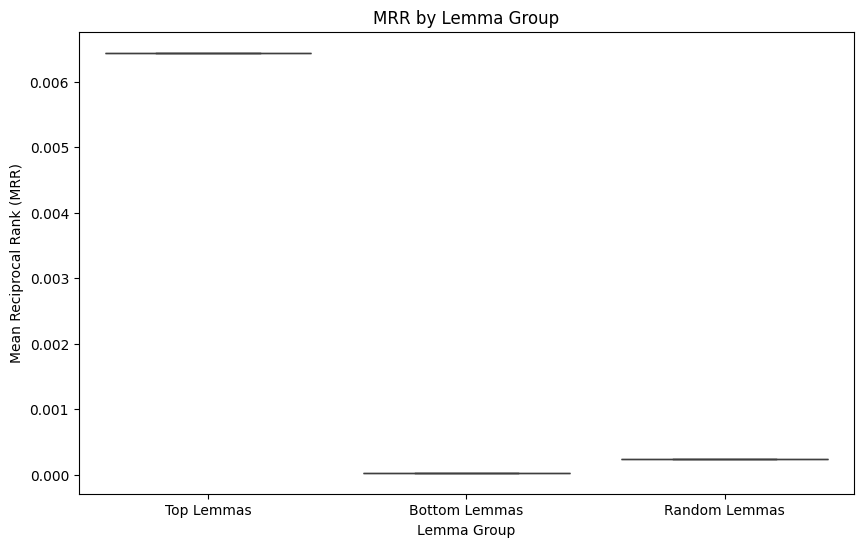

In [5]:
# Создание DataFrame для визуализации
mrr_data = [
    {'File': 'Top Lemmas', 'MRR': mrr_top},
    {'File': 'Bottom Lemmas', 'MRR': mrr_bottom},
    {'File': 'Random Lemmas', 'MRR': mrr_random}
]

df_mrr = pd.DataFrame(mrr_data)

# Визуализация с использованием boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='File', y='MRR', data=df_mrr)
plt.title('MRR by Lemma Group')
plt.ylabel('Mean Reciprocal Rank (MRR)')
plt.xlabel('Lemma Group')
plt.show()